In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from source.network.ravepqmf import PQMF
import librosa
from source.network.metrics import spectral_distance, multiscale_stft

def load_audio(file_path, sr=44100):
    audio, _ = librosa.load(file_path, sr=sr)
    return torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0)

def plot_waveform(signal, title):
    plt.figure(figsize=(12, 4))
    plt.plot(signal.squeeze().numpy())
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram(signal, sr, title):
    D = librosa.stft(signal.squeeze().numpy())
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def plot_frequency_domain(signal, sample_rate=44100, title=''):
    fft = np.fft.fft(signal.squeeze().numpy())
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    plt.figure(figsize=(12, 4))
    plt.xscale("log")
    plt.plot(freqs, np.abs(fft))
    plt.title(title)
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xscale('log')
    plt.show()

def plot_spectral_distance(x_stfts, y_stfts, scales):
    for i, scale in enumerate(scales):
        plt.figure(figsize=(12, 4))
        plt.imshow(np.abs(x_stfts[i][0] - y_stfts[i][0]).numpy(), aspect='auto', cmap='viridis')
        plt.title(f'Spectral Distance (scale {scale})')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time Frame')
        plt.ylabel('Frequency Bin')
        plt.show()


Part 1: PQMF Decomposition and Reconstruction


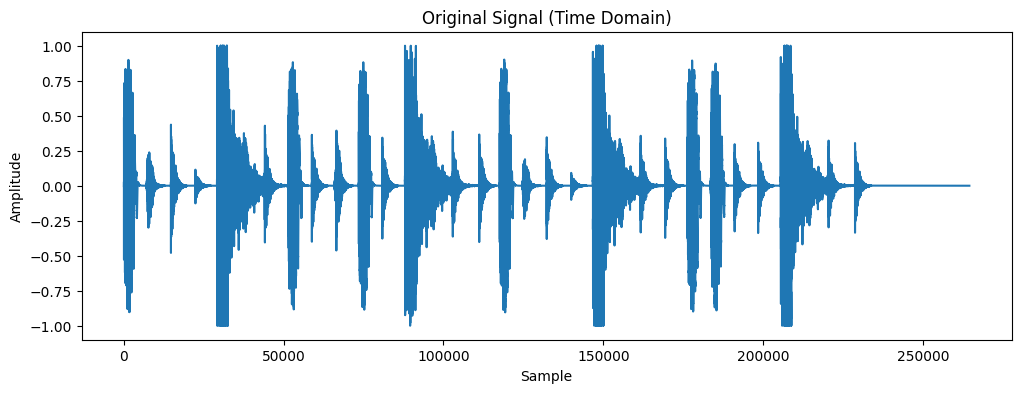

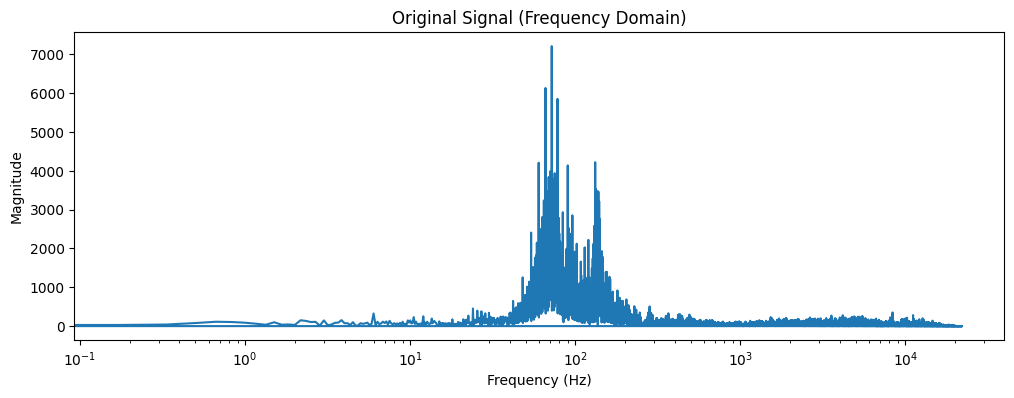

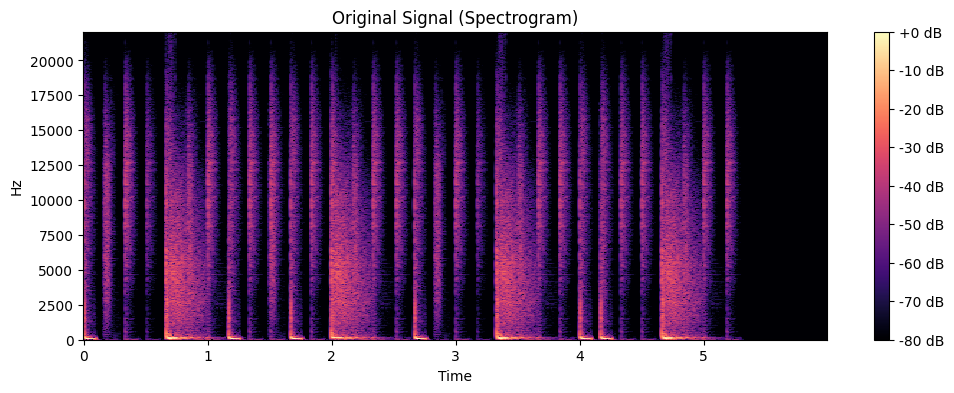

In [2]:
print("Part 1: PQMF Decomposition and Reconstruction")
signal = load_audio("80s Beat 90 bpm_dry.wav")
plot_waveform(signal, "Original Signal (Time Domain)")
plot_frequency_domain(signal, title="Original Signal (Frequency Domain)")
plot_spectrogram(signal, sr=44100, title="Original Signal (Spectrogram)")


## Initialize PQMF

In [3]:
pqmf = PQMF(attenuation=80, n_band=4)

In [4]:
from torch.nn import functional as F

# pad signal
pad_length = (4 - (signal.shape[-1] % 4)) % 4
padded_signal = F.pad(signal, (0, pad_length))

decomposed = pqmf.forward(padded_signal)
reconstructed = pqmf.inverse(decomposed)

print(signal.shape)
print(decomposed.shape)

torch.Size([1, 1, 264573])
torch.Size([1, 4, 66144])


In [5]:
# To play audio in the notebook (if using Jupyter)
from IPython.display import Audio

for i in range(decomposed.shape[1]):
        # Convert to numpy array and specify the sample rate
    audio_data = decomposed[0, i, :].cpu().numpy()
    display(Audio(audio_data, rate=44100))

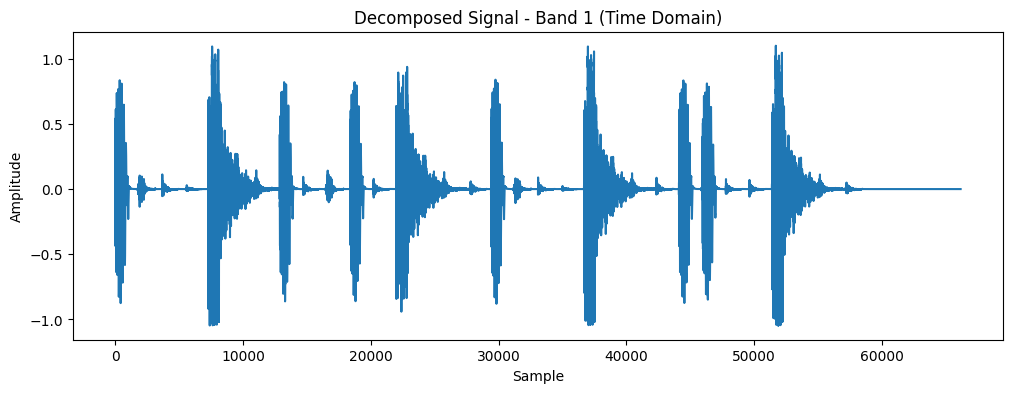

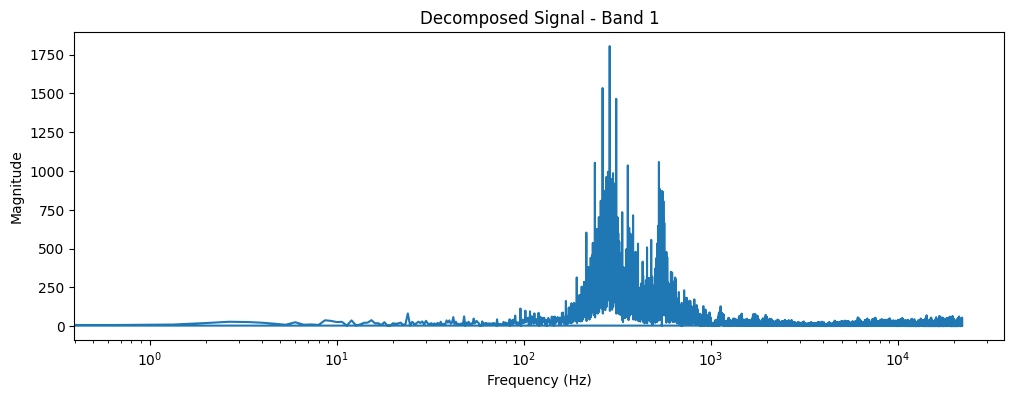

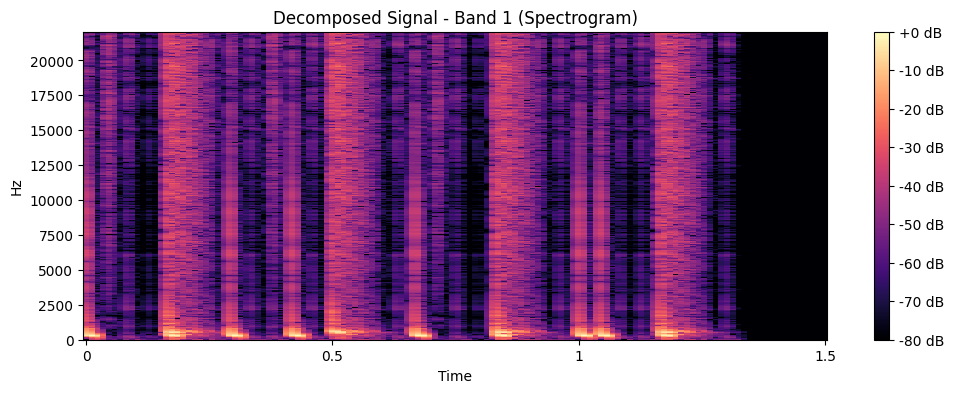

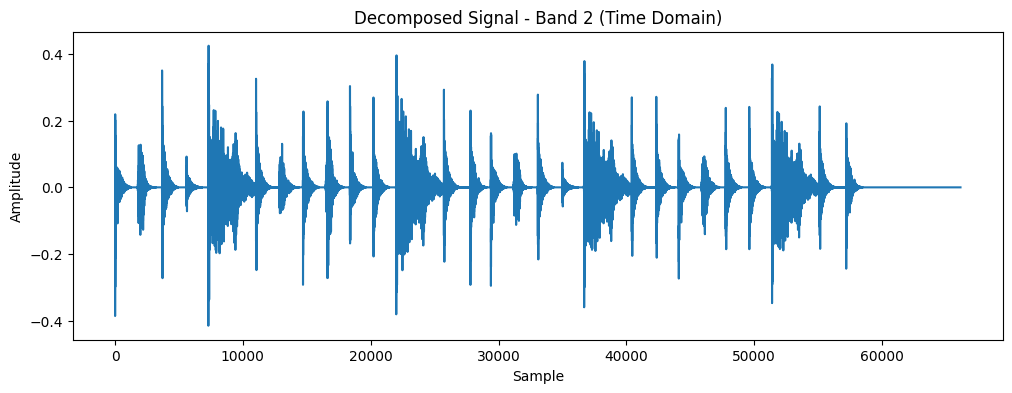

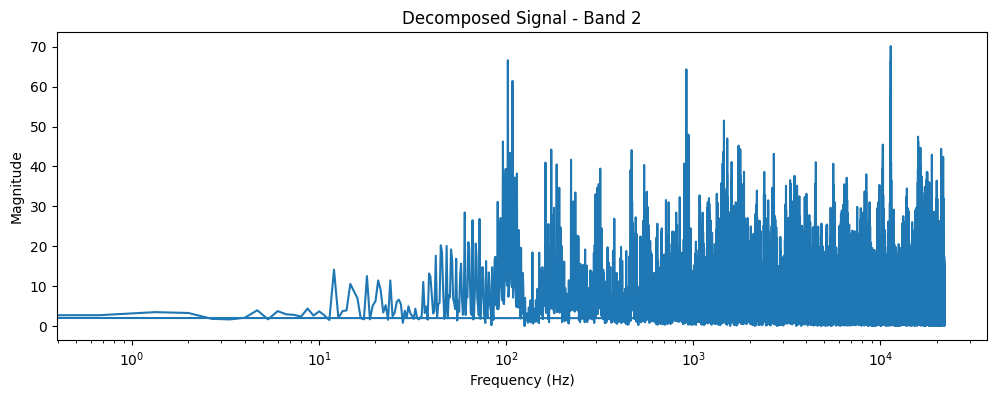

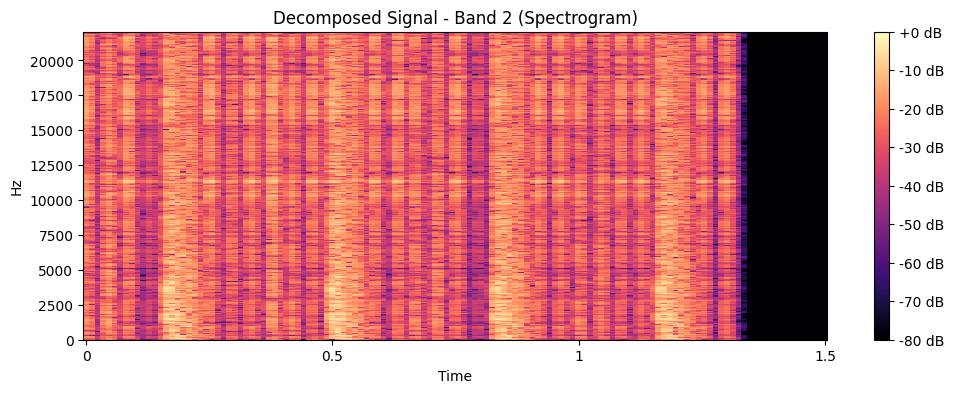

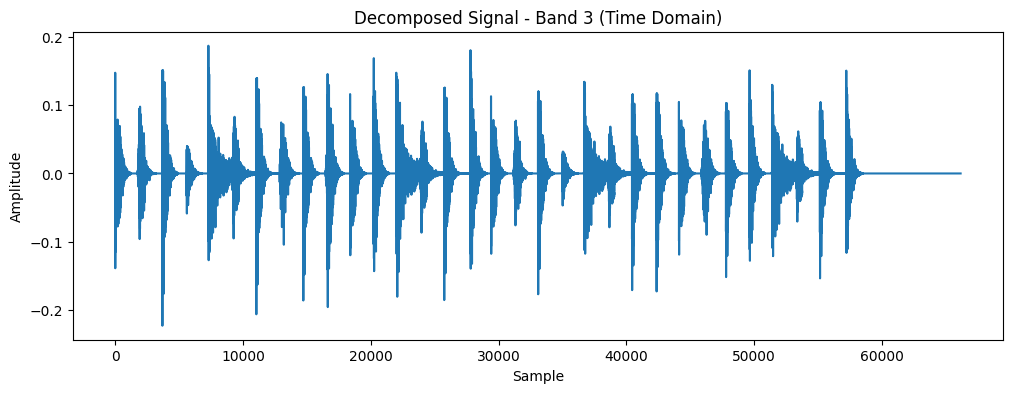

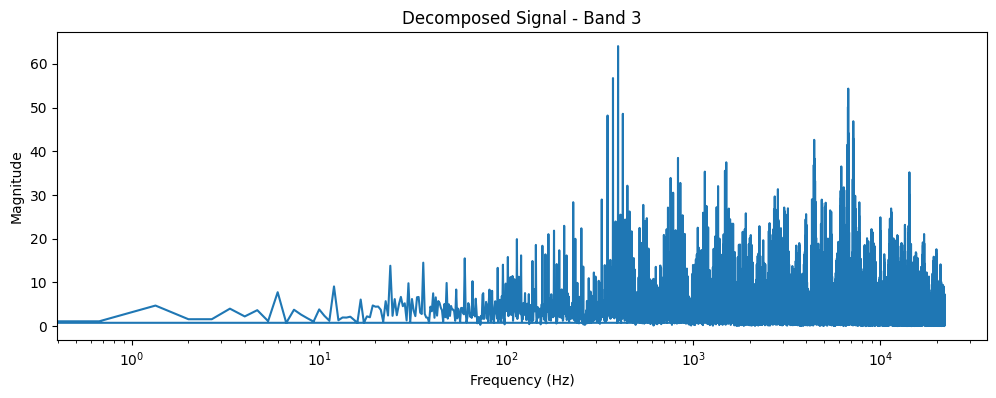

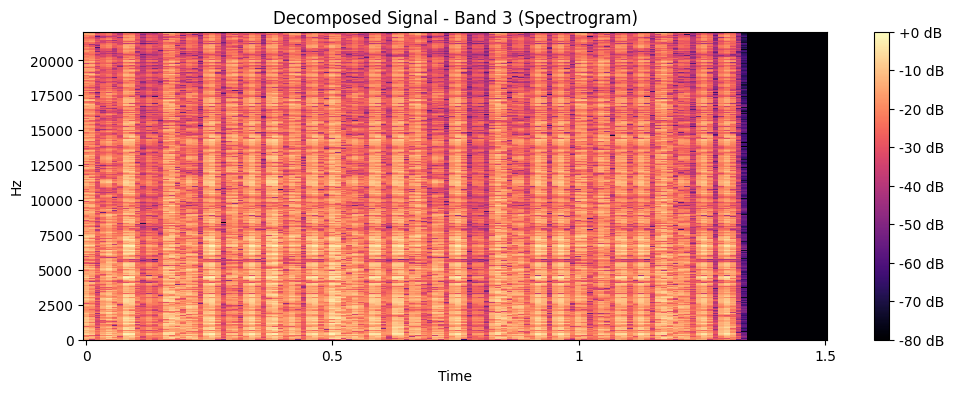

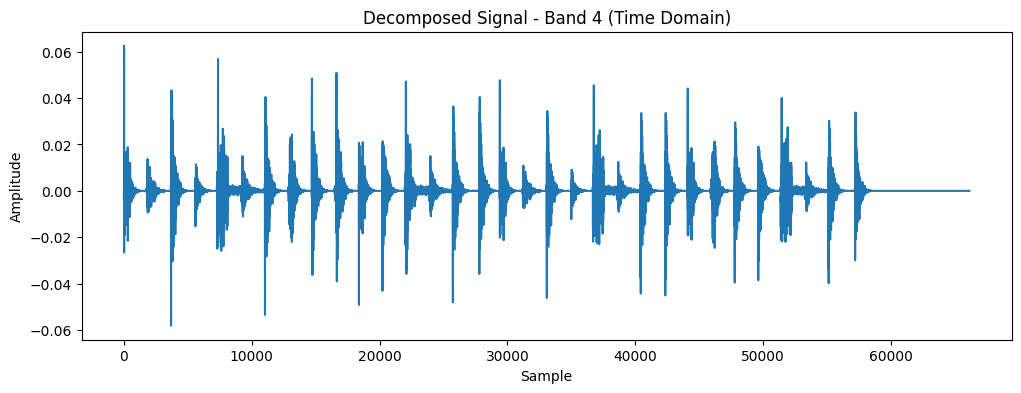

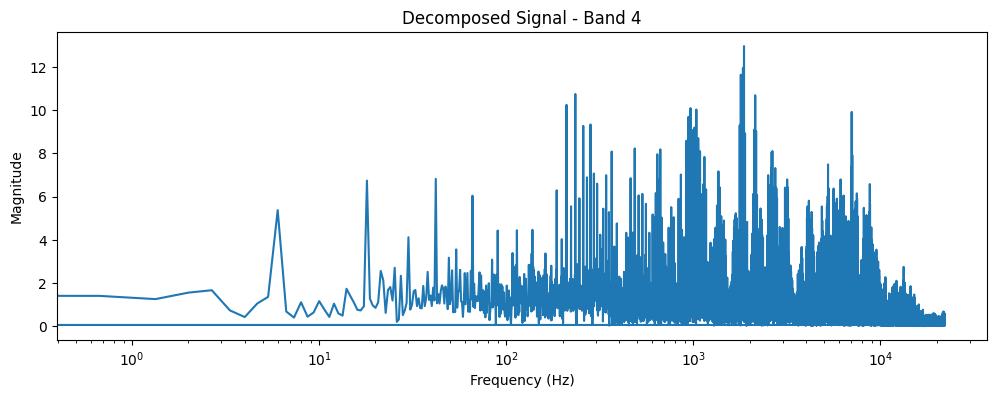

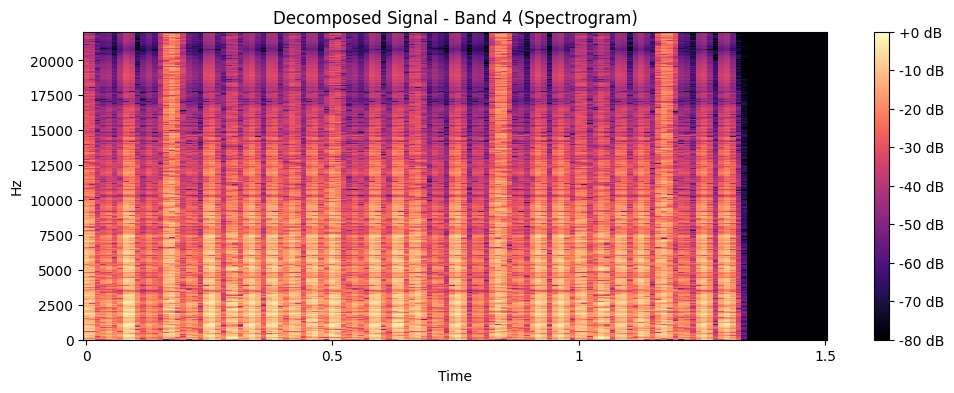

In [6]:
# Plot each band separately
for i in range(decomposed.shape[1]):
    signal = decomposed[0, i, :]
    plot_waveform(signal, f"Decomposed Signal - Band {i+1} (Time Domain)")
    plot_frequency_domain(signal, title=f"Decomposed Signal - Band {i+1}")
    plot_spectrogram(signal, sr=44100, title=f"Decomposed Signal - Band {i+1} (Spectrogram)")

## Reconstructed signal

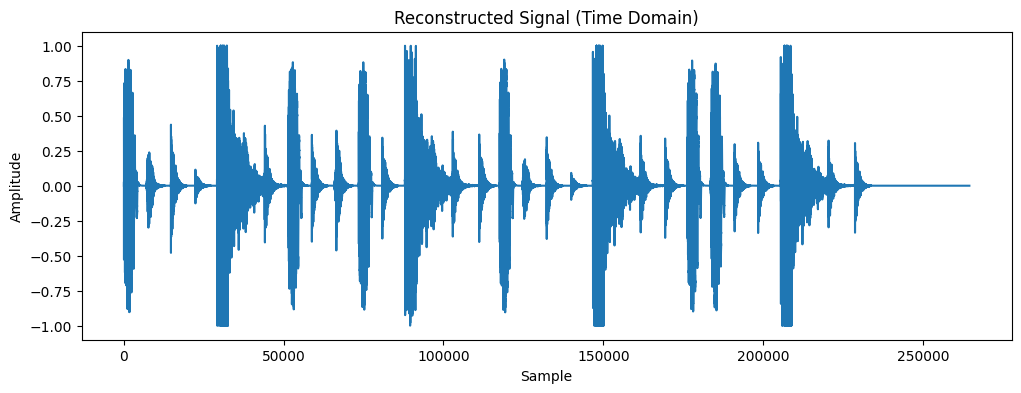

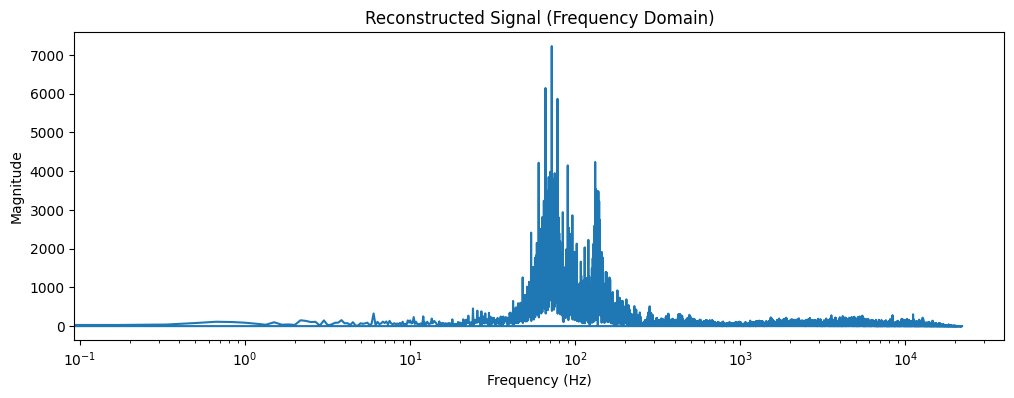

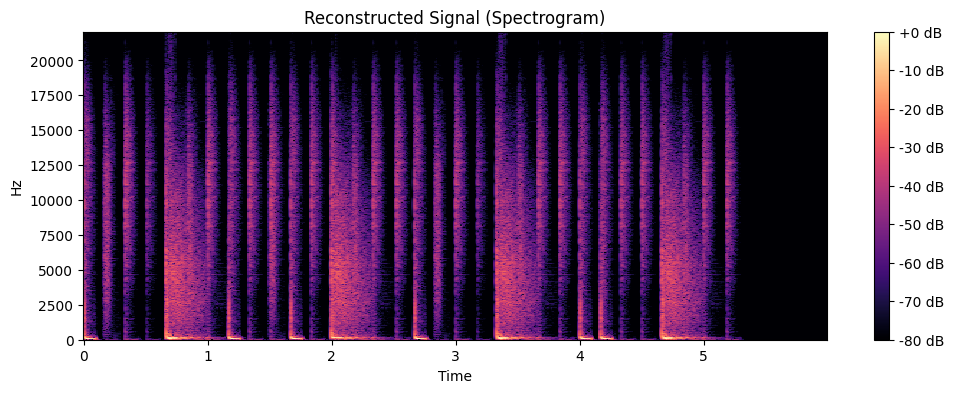

In [7]:

plot_waveform(reconstructed, "Reconstructed Signal (Time Domain)")
plot_frequency_domain(reconstructed, title="Reconstructed Signal (Frequency Domain)")
plot_spectrogram(reconstructed, sr=44100, title="Reconstructed Signal (Spectrogram)")